# Capstone - AWS Machine Learning Engineer
## AEP Hourly Energy Consumption

In [3]:
!pip install xgboost
#!pip install -U pip
#!pip install -U setuptools wheel
#!pip install autogluon --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.1 MB/s eta 0:00:00:00:0100:01


### Importing Libraries

In [1]:
import os
import boto3
import sagemaker

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [5]:
#library for signal filtering
from scipy import signal

# Library for statistical test of stationarity
from statsmodels.tsa.stattools import adfuller

#Library for time series decomposition
import statsmodels.api as sm

#Library to create auto-correlation and partial auto-correlation plots
from statsmodels.graphics import tsaplots

#Libraries to build AR, MA, ARMA, and SARIMA time-series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg


### AWS Macros

In [7]:
session = sagemaker.Session()
bucket= session.default_bucket()
region = session.boto_region_name
role = sagemaker.get_execution_role()

In [4]:
!unzip AEP_hourly.csv.zip

Archive:  AEP_hourly.csv.zip
  inflating: AEP_hourly.csv          


os.environ["DATABASE_PATH"] = "s3://"+ bucket+ "/AEP_hourly/"
!aws s3 cp AEP_hourly ${DATABASE_PATH} --recursive

### Data Overview

In [7]:
df = pd.read_csv('AEP_hourly.csv')

In [38]:
#viewing dataframe head
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [39]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [40]:
#checking for duplicate rows in dataframe
duplicate_df = df[df.duplicated()]

print("Number of duplicate Rows except first occurrence based on all columns are:")
duplicate_df.sum()

Number of duplicate Rows except first occurrence based on all columns are:


Datetime      0
AEP_MW      0.0
dtype: object

In [41]:
#checking data size
df.shape

(121273, 2)

In [42]:
#checking data types of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [43]:
#checking missing value
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [57]:
#checking for missing hours in the time-series
out = pd.date_range(df['Datetime'].min(), df['Datetime'].max(), freq='H').difference(df['Datetime'])
print(out)

DatetimeIndex(['2004-10-31 02:00:00', '2005-04-03 03:00:00',
               '2005-10-30 02:00:00', '2006-04-02 03:00:00',
               '2006-10-29 02:00:00', '2007-03-11 03:00:00',
               '2007-11-04 02:00:00', '2008-03-09 03:00:00',
               '2008-11-02 02:00:00', '2009-03-08 03:00:00',
               '2009-11-01 02:00:00', '2010-03-14 03:00:00',
               '2010-11-07 02:00:00', '2010-12-10 00:00:00',
               '2011-03-13 03:00:00', '2011-11-06 02:00:00',
               '2012-03-11 03:00:00', '2012-11-04 02:00:00',
               '2012-12-06 04:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2014-03-11 14:00:00', '2015-03-08 03:00:00',
               '2016-03-13 03:00:00', '2017-03-12 03:00:00',
               '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)


In [8]:
#since this is a time-series problem, i'll be setting 'Datetime' as index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [9]:
#sorting index in ascending order
df.sort_index(inplace=True)

In [10]:
#resampling and filling missing hours with preceeding hour's energy value 
df = df.resample('H').first().fillna(method='ffill')

/tmp/ipykernel_8800/926166468.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('H').first().fillna(method='ffill')


In [11]:
#checking missing hours again
out = pd.date_range(df.index.min(), df.index.max(), freq='H').difference(df.index)
print(out)

DatetimeIndex([], dtype='datetime64[ns]', freq='H')


In [49]:
df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [50]:
#checking final dataframe tail
df.tail()

,AEP_MW
Datetime,
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0
2018-08-02 23:00:00,15964.0
2018-08-03 00:00:00,14809.0


### Data Visualization and Statistical Analysis

In [90]:
#checking descriptive statistics of timeseries
round(df.describe(),2)

,AEP_MW
count,121296.00
mean,15499.18
std,2591.36
min,9581.00
25%,13629.00
50%,15309.00
75%,17200.00
max,25695.00


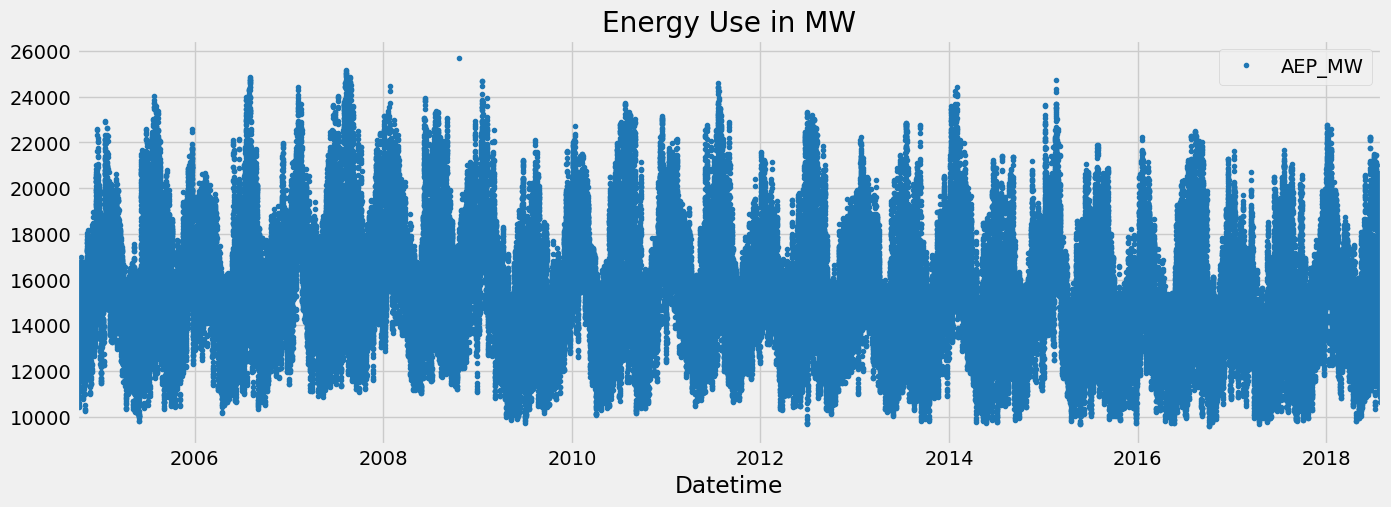

In [62]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy Use in MW')
plt.show()

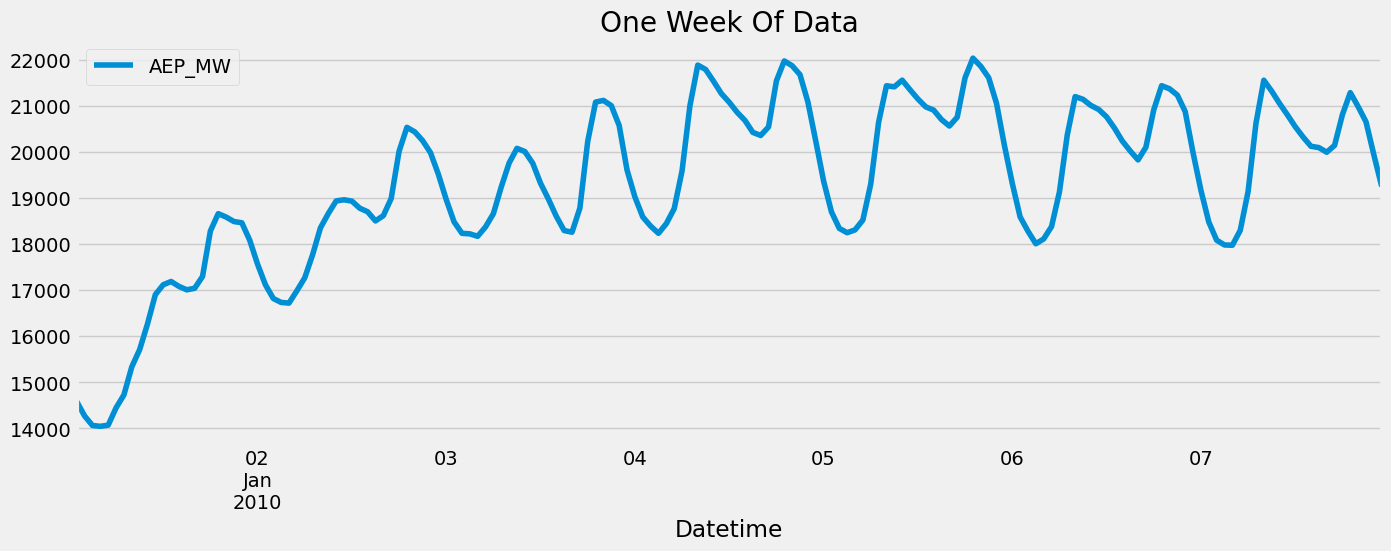

In [105]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='One Week Of Data')
plt.show()

#### Decomposition of Time-series
I'll be decomposing the time-series to separately visualize its:

- Trend
- Seasonality
- Residual/White/Random Noise

In [96]:
decomposition = sm.tsa.seasonal_decompose(df, period = 9)

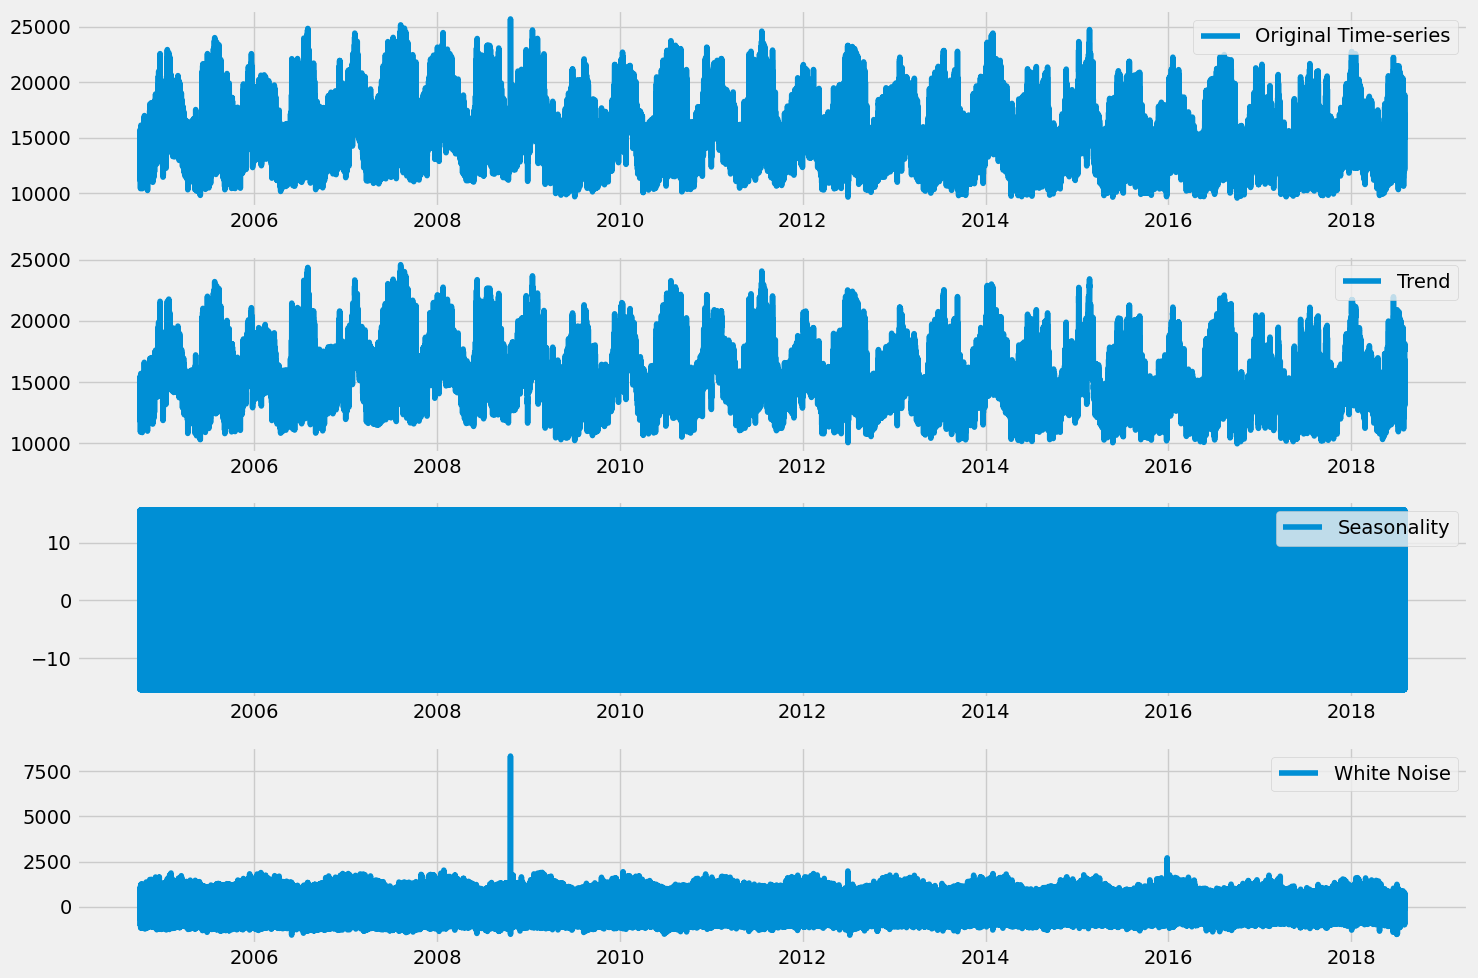

In [97]:
#Visualizing time series components in a single plot
plt.figure(figsize = (15, 10))

plt.subplot(411)
plt.plot(df, label = 'Original Time-series')
plt.legend(loc = 'upper right')

plt.subplot(412)
plt.plot(decomposition.trend, label = 'Trend')
plt.legend(loc = 'upper right')

plt.subplot(413)
plt.plot(decomposition.seasonal, label = 'Seasonality')
plt.legend(loc = 'upper right')

plt.subplot(414)
plt.plot(decomposition.resid, label = 'White Noise')
plt.legend(loc = 'upper right')

plt.tight_layout()

### Train/Test Split

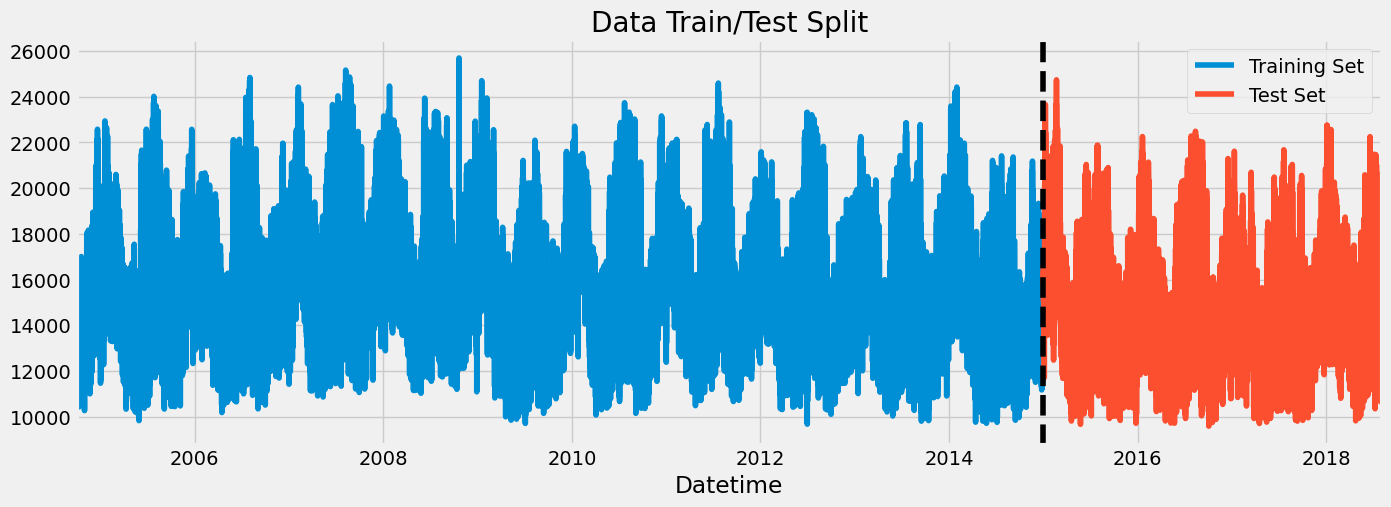

In [87]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Model Evaluation Metrics
Before embarking on model building, i need to select which evaluation metrics to assess the models against:

MAE
Mean absolute error is how far away the forecasts are in comparison to the actual values in the time series. Its measured as the mean of the absolute error between all predictions and corresponding actual value.

RMSE
Root mean square error also measures how far away the forecasts are in comparison to the actual values, but its the mean of the squares of the error between time-series values and correspond forecast.

### Custom function for model performance evaluation

In [45]:
def plot_predicted_output(model, ax):
    
    """
    Function to visualize prediction
    Input: model, pyplot object
    Output: plots of predictions
    """
    
    predictions_test = model.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1)) 
    predictions_train = model.predict(start=0,end=(train.shape[0]-1))

    # Setting indices of the test data into prediction values
    predictions_test.index = test.index
    predictions_train.index = train.index
    
    # Computing the AIC and RMSE metrics for the model and printing it into title of the plot
    train.plot(ax = ax, label = 'train', linestyle = 'dashed',
                    title = 'AIC: {}'.format(np.round(model.aic, 2)) + 
                           ' , ' +
                           'MAE on Test Data: {}'.format(np.round(np.sqrt(mean_absolute_error(test, predictions_test)), 2)+
                            ' , ' +                              
                           'RMSE on Test Data: {}'.format(np.round(np.sqrt(mean_squared_error(test, predictions_test)), 2)))
    
    # Plotting the test data
    test.plot(ax = ax)#, color = 'green', linestyle = 'dashed',) 
    
    # Plotting the forecasted data
    predictions_test.plot(ax = ax)#, color = 'yellow')
    predictions_train.plot(ax = ax, linestyle = 'dashed')#, color = 'green')
    
    # Adding the legends sequentially
    ax.legend(['train data', 'test data', 'forecast on test data', 'forecast on train data'])

### Modelling
#### Baseline Model - Moving Average (MA)

The Moving Average modelling of time-series is essentially a linear regression that makes use of the past error terms as predictors. Forecast (prediction) at any time in the future is the linear combination of weighted past residuals. The name should not be confused to mean moving average of past datapoints. Instead, it is the linear combination of past error terms.

The number of lags to be used in MA is called the order of MA. And its selected to include lags that have the most statistically significant correlation to the series

#### Feature Engineering - Auto Correlation Function
Auto Correlation Function (ACF) plot is a bar chart of coefficients of correlation between a time series and its lags. In simple terms, ACF explains how the present value of a given time series is correlated with its past values (1-unit past,.…, n-unit past).

We can estimate the optimal order of MA from the ACF plot. It can be observed by how many lags are above or below the confidence interval (i.e have statistically significant correlation to the series).

<Figure size 1600x500 with 0 Axes>

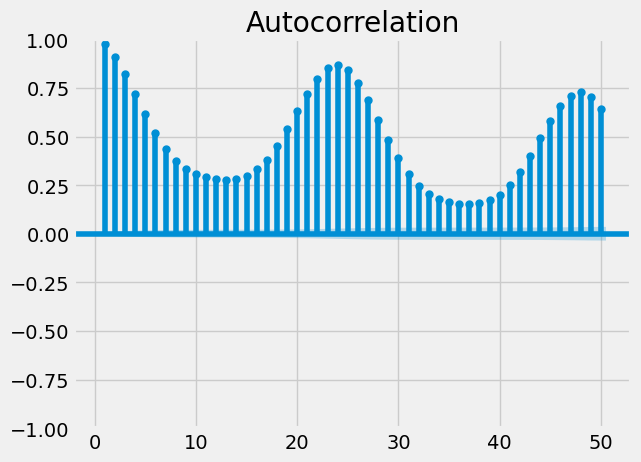

In [106]:
plt.figure(figsize = (16, 5))

# Creating and plotting the ACF charts starting from lag = 1
tsaplots.plot_acf(train, zero = False)
plt.show()

Observation:

- On the x-axis are the lags of the series. On the y-axis are the correlations between each lag and the series.
- Correlation could be positive or negative ranging from 1 to -1.
- The light blue shaded region represent the confidence interval
- More than 40 lags are above the confidence interval (i.e have statistically significant positive correlation with the series).
- Since each lag is a feature/predictor, i'll limit my q-parameter (order of MA) to 15
- After seeing how much computation time and memory needed for 15 lags, I'll limit my order of MA to first 5 lags with the most correlations

In [108]:
# Creating MA model with parameter q = 5
ma_model = ARIMA(train, order = (0, 0, 5)).fit()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [109]:
#statistical summary of MA model
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:                89855
Model:                 ARIMA(0, 0, 5)   Log Likelihood             -689112.382
Date:                Mon, 18 Dec 2023   AIC                        1378238.763
Time:                        18:28:44   BIC                        1378304.605
Sample:                    10-01-2004   HQIC                       1378258.841
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.574e+04     12.527   1256.617      0.000    1.57e+04    1.58e+04
ma.L1          1.4210      0.001   1073.505      0.000       1.418       1.424
ma.L2          1.2784      0.002    748.574      0.0

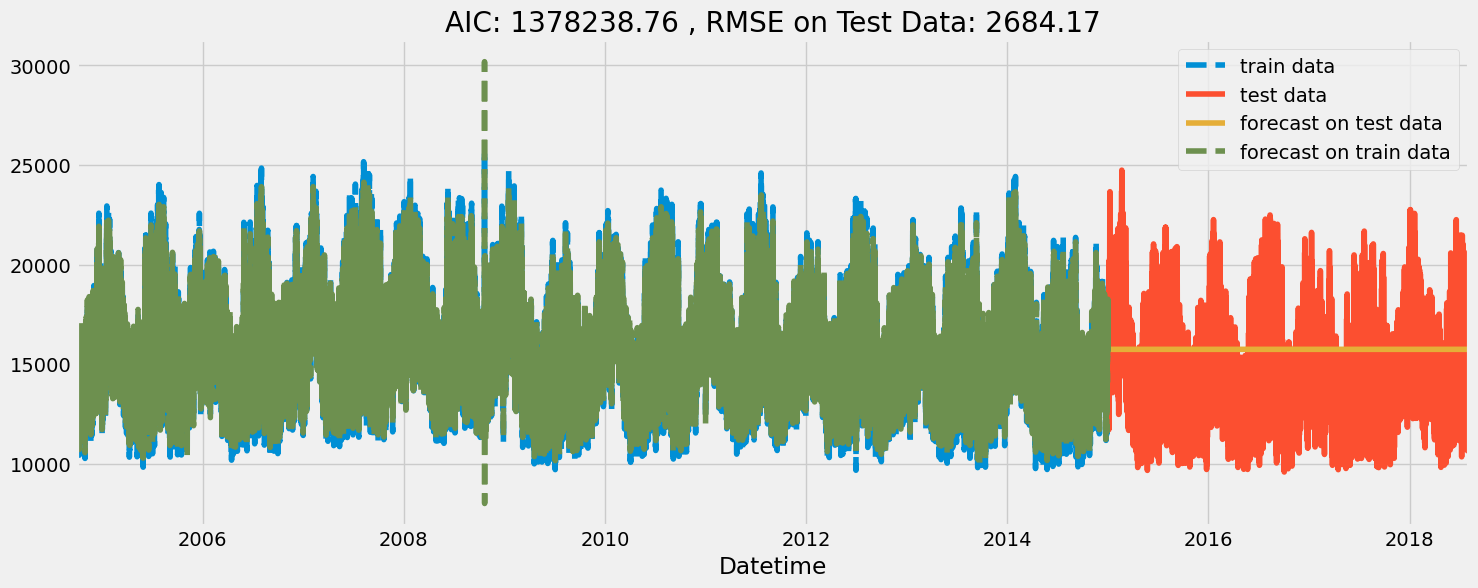

In [121]:
# Plotting the predictions along with train and test
fig, ax = plt.subplots(figsize = (16, 6))
plot_predicted_output(ma_model, ax)

Observation:

- Predictions on unseen test data appear to quickly run towards the long-run mean of the series
- The performance on unseen testcdata could be improved if i would include more lags that have statistically significant correlation. However, i didnt because the model building did not run in reasonable time

### Model 1 - AutoRegressive (AR)

In AR, the forecast of a series at time t is a linear function of the previous values of the same time series. The order p of an autoregression model is the number of lags in the series that are used to predict the value at the present time.

The number of lags to be used in AR is called the order of AR. And its selected to include lags that have the most statistically significant correlation to the series.

#### Feature Engineering - Partial Auto Correlation Function (PACF)
PACF describes the partial correlation between the series and its own lags. The partial correlation for a lag is the unique correlation between the series and that lag after taking out the intervening correlations of other lags.

We can estimate the optimal lags for AR Model from the PACF plot. It can be observed by how many lags are outside the confidence interval (i.e have statistically significant partial correlation with the series).

<Figure size 1600x500 with 0 Axes>

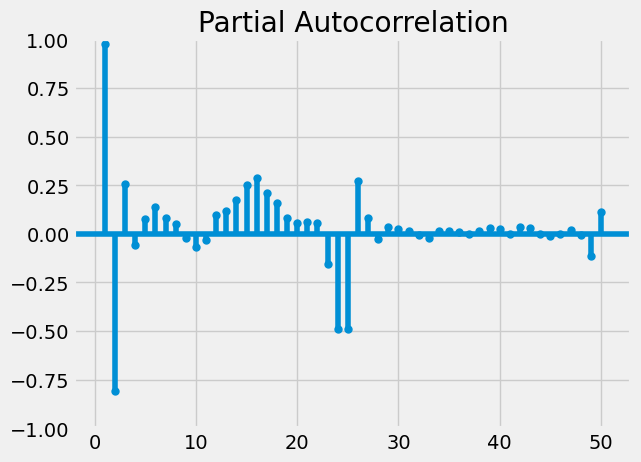

In [123]:
plt.figure(figsize = (16, 5))

# Creating and plotting the PACF charts starting from lag = 1
tsaplots.plot_pacf(train, zero = False)
plt.show()

In [125]:
# Creating an AR model with parameter p = 4
ar_model = ARIMA(train, order = (4, 0, 0)).fit()

In [126]:
#statistical summary of AR model
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:                89855
Model:                 ARIMA(4, 0, 0)   Log Likelihood             -647058.056
Date:                Mon, 18 Dec 2023   AIC                        1294128.112
Time:                        18:33:39   BIC                        1294184.547
Sample:                    10-01-2004   HQIC                       1294145.321
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.574e+04     33.864    464.835      0.000    1.57e+04    1.58e+04
ar.L1          1.9880      0.001   1447.791      0.000       1.985       1.991
ar.L2         -1.3382      0.001   -991.508      0.0

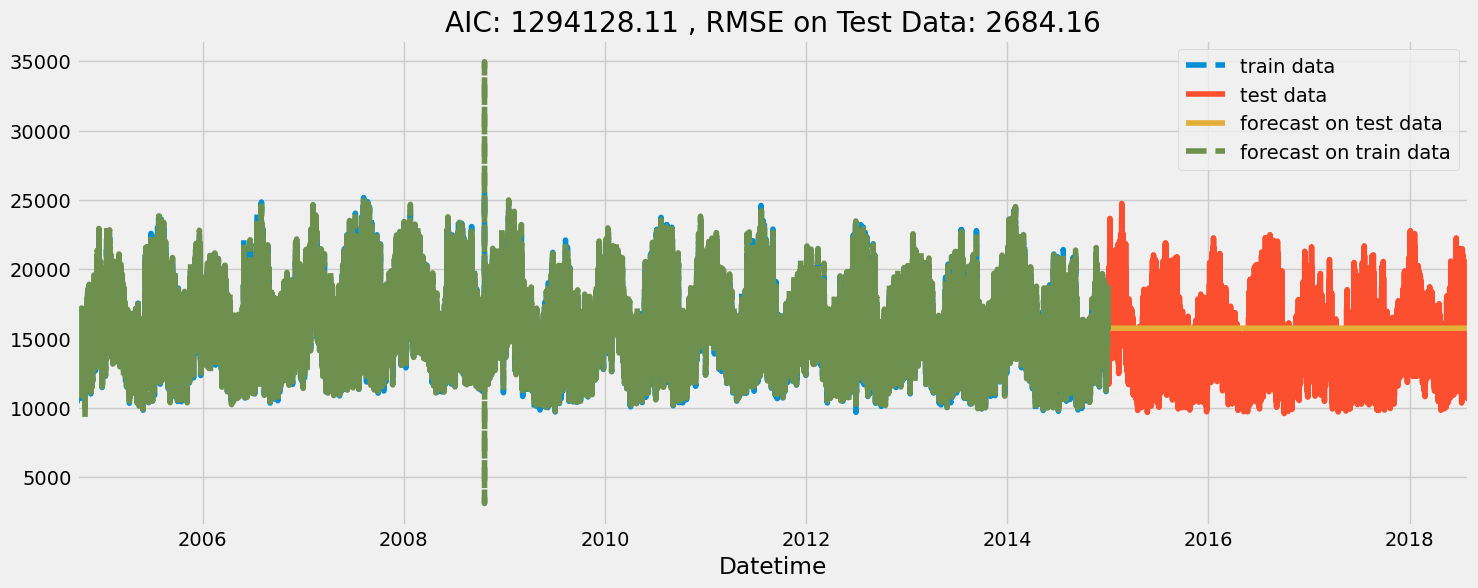

In [127]:

# Plotting the forecasted values along with train and test

fig, ax = plt.subplots(figsize = (16, 6))

plot_predicted_output(ar_model, ax)

### Model 2 - AutoRegressive Moving Average (ARMA)

ARMA is simply the combination of the Autoregressive and moving average models. Forecast at any time is a linear function of past values and past errors/residuals.

Similarly, optimal orders of AR and MA can be obtained from the PACF and ACF plots respectively.

In [129]:
# Creating an ARMA model with parameters p = 4 and q = 5
arma_model = ARIMA(train, order = (4, 0, 5)).fit()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [130]:
#statistical summary of ARMA model
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:                89855
Model:                 ARIMA(4, 0, 5)   Log Likelihood             -640810.669
Date:                Mon, 18 Dec 2023   AIC                        1281643.338
Time:                        18:40:37   BIC                        1281746.803
Sample:                    10-01-2004   HQIC                       1281674.889
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.574e+04     43.288    363.642      0.000    1.57e+04    1.58e+04
ar.L1          3.3411      0.019    173.719      0.000       3.303       3.379
ar.L2         -4.4322      0.050    -88.839      0.0

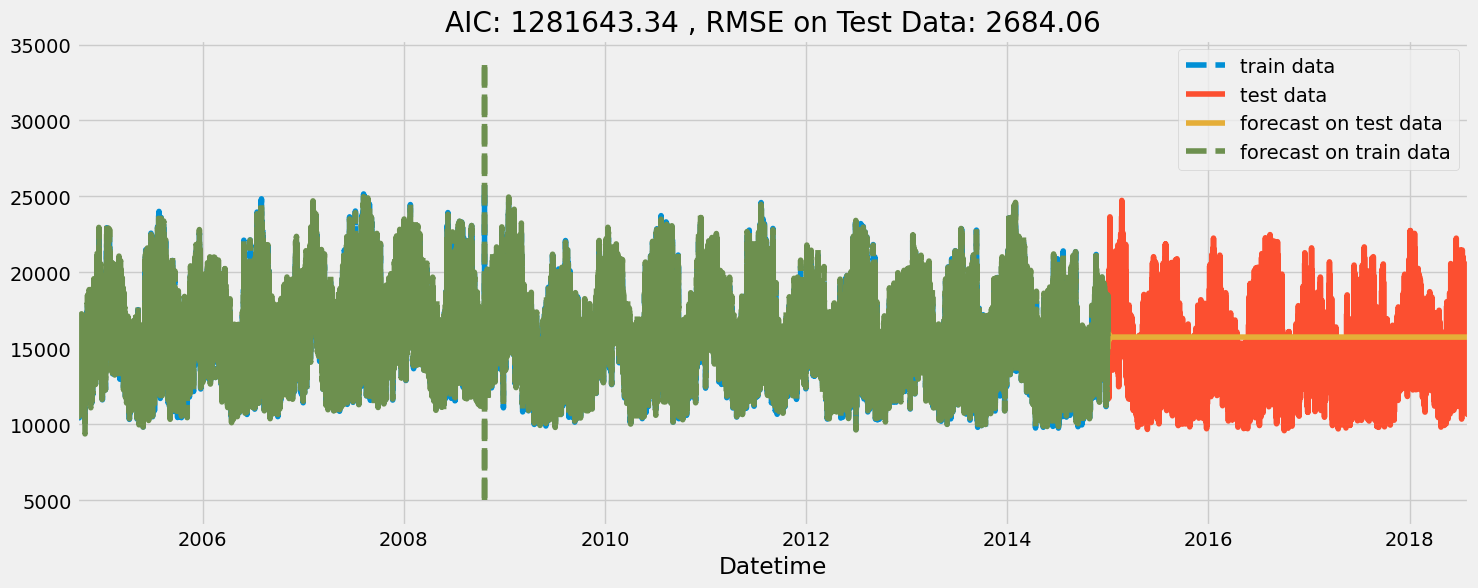

In [131]:
# Plotting the forecasted values along with train and test for all the models

fig, ax = plt.subplots(figsize = (16, 6))

plot_predicted_output(arma_model, ax)

Observation

- It appears the ARIMA class of modeling is not a good fit for this problem
- I'll try other modelling techniques

In [6]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [88]:
train.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [89]:
train['Datetime'] = train.index
train['item_id'] = '1' #train.Datetime.astype(str)

test['Datetime'] = test.index
test['item_id'] = '1'

/tmp/ipykernel_8800/170786822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Datetime'] = train.index
/tmp/ipykernel_8800/170786822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['item_id'] = '1' #train.Datetime.astype(str)
/tmp/ipykernel_8800/170786822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [90]:
train.tail()

,AEP_MW,Datetime,item_id
Datetime,,,
2014-12-31 19:00:00,18161.0,2014-12-31 19:00:00,1
2014-12-31 20:00:00,17865.0,2014-12-31 20:00:00,1
2014-12-31 21:00:00,17568.0,2014-12-31 21:00:00,1
2014-12-31 22:00:00,17295.0,2014-12-31 22:00:00,1
2014-12-31 23:00:00,16941.0,2014-12-31 23:00:00,1


In [91]:
test.tail()

,AEP_MW,Datetime,item_id
Datetime,,,
2018-08-02 20:00:00,17673.0,2018-08-02 20:00:00,1
2018-08-02 21:00:00,17303.0,2018-08-02 21:00:00,1
2018-08-02 22:00:00,17001.0,2018-08-02 22:00:00,1
2018-08-02 23:00:00,15964.0,2018-08-02 23:00:00,1
2018-08-03 00:00:00,14809.0,2018-08-03 00:00:00,1


In [77]:
test.set_index('item_id', inplace=True)

In [78]:
test['timestamp'] = test['Datetime']
test = test.drop(columns=["Datetime"])
test.tail()

/tmp/ipykernel_8800/2544855040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['timestamp'] = test['Datetime']


,AEP_MW,timestamp
item_id,,
1,17673.0,2018-08-02 20:00:00
1,17303.0,2018-08-02 21:00:00
1,17001.0,2018-08-02 22:00:00
1,15964.0,2018-08-02 23:00:00
1,14809.0,2018-08-03 00:00:00


In [92]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train,
    id_column="item_id",
    timestamp_column="Datetime"
)
train_data.head()

AEP_MW
item_id timestamp                   
1       2004-10-01 01:00:00  12379.0
        2004-10-01 02:00:00  11935.0
        2004-10-01 03:00:00  11692.0
        2004-10-01 04:00:00  11597.0
        2004-10-01 05:00:00  11681.0

In [94]:
test_data = TimeSeriesDataFrame.from_data_frame(
    test,
    id_column="item_id",
    timestamp_column="Datetime"
)
test_data.head()

AEP_MW
item_id timestamp                   
1       2015-01-01 00:00:00  16375.0
        2015-01-01 01:00:00  16172.0
        2015-01-01 02:00:00  15968.0
        2015-01-01 03:00:00  15749.0
        2015-01-01 04:00:00  15727.0

test_data = test_data.assign(item_id = 1)

test_data.head()

In [ ]:
test_data = test

In [35]:
predictor = TimeSeriesPredictor(
    path="autogluon-m4-hourly",
    target="AEP_MW",
    eval_metric="MAE",
    freq='H',
    prediction_length=48,
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=100,
)

Beginning AutoGluon training... Time limit = 100s
AutoGluon will save models to 'autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Sep 6 21:15:41 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       2.11 GB / 3.76 GB (56.1%)
Disk Space Avail:   4.50 GB / 4.78 GB (94.2%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'freq': 'H',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'AEP_MW',
 'time_limit': 100,
 'verbosity': 2}

Provided train_data has 8985

In [38]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: DirectTabular


In [95]:
#test_data = test #TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

item_id = 1
y_past = train_data.loc[item_id]["AEP_MW"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["AEP_MW"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

KeyError: 1

<Figure size 2000x300 with 0 Axes>

In [ ]:
# Plotting the predictions along with train and test
fig, ax = plt.subplots(figsize = (16, 6))
plot_predicted_output(predictor, ax)

### Regression Modeling

#### Feature Engineering

I'll generate features from the datetime

In [65]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

#### Hourly Distribution of Energy

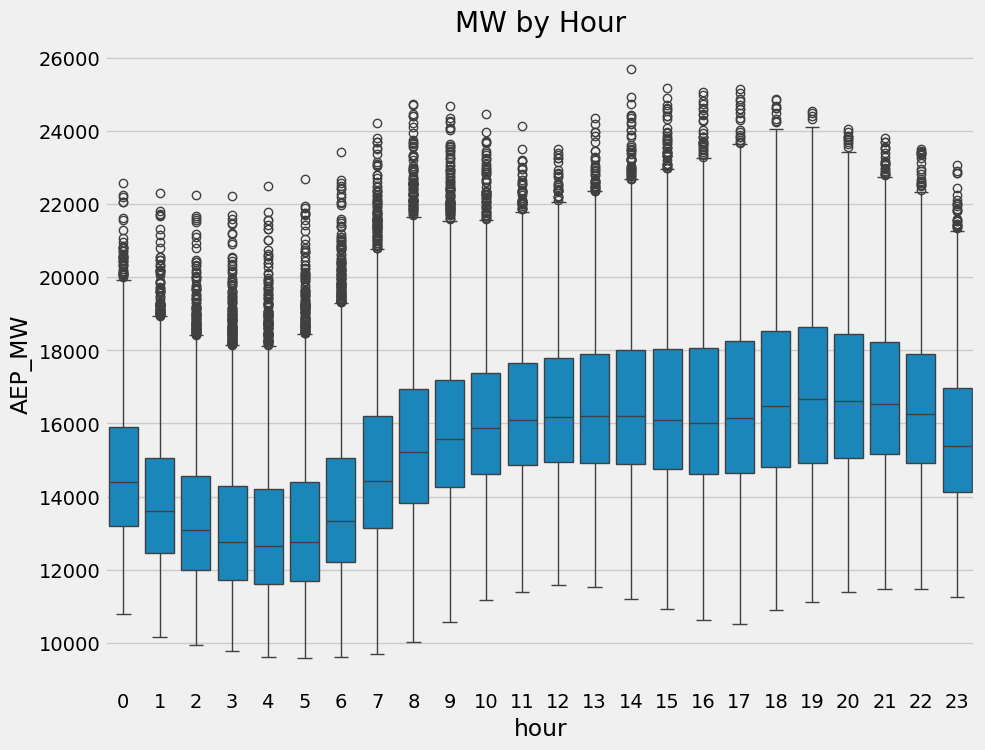

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

#### Monthly Distribution of Energy

/tmp/ipykernel_8119/3087536141.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')


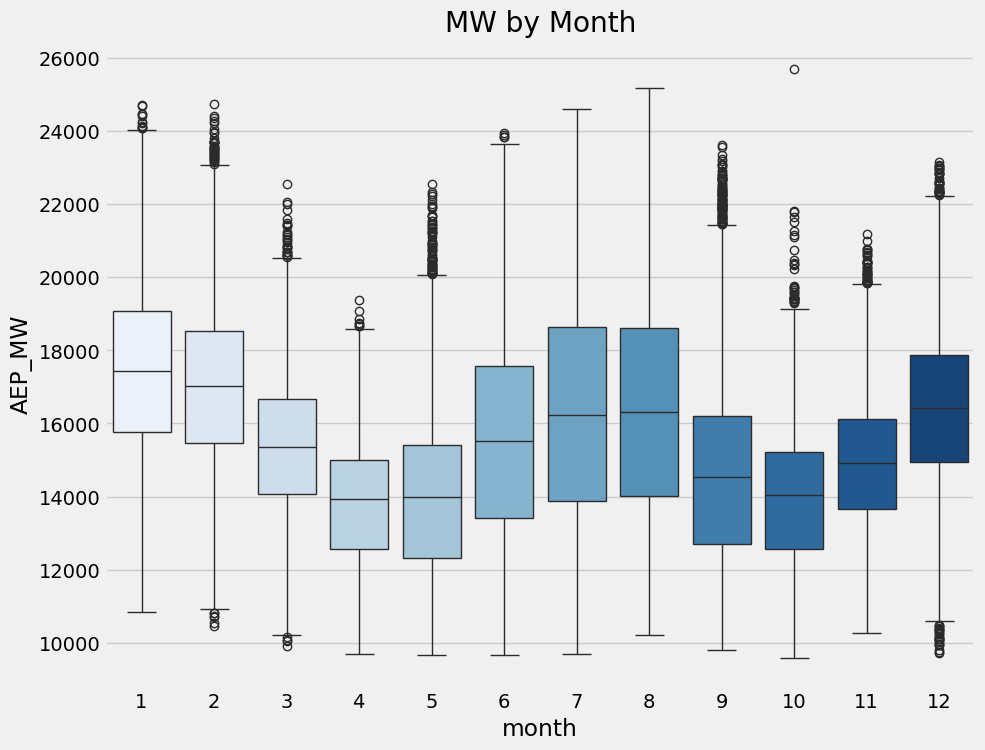

In [68]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [70]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [71]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15792.72126	validation_1-rmse:14861.44382


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:55:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6034.36926	validation_1-rmse:5149.25857
[200]	validation_0-rmse:2702.83095	validation_1-rmse:2160.15706
[300]	validation_0-rmse:1755.50432	validation_1-rmse:1668.24432
[400]	validation_0-rmse:1515.81760	validation_1-rmse:1657.80242
[403]	validation_0-rmse:1511.42676	validation_1-rmse:1657.88214


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

#### Feature Importance

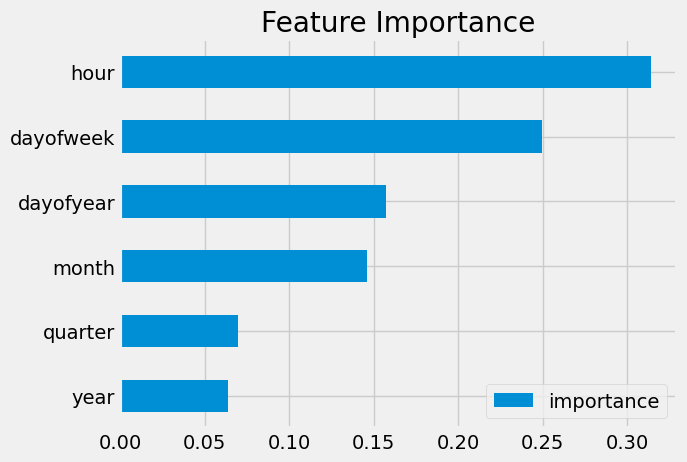

In [72]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Plotting the forecasted values along with train and test for all the models

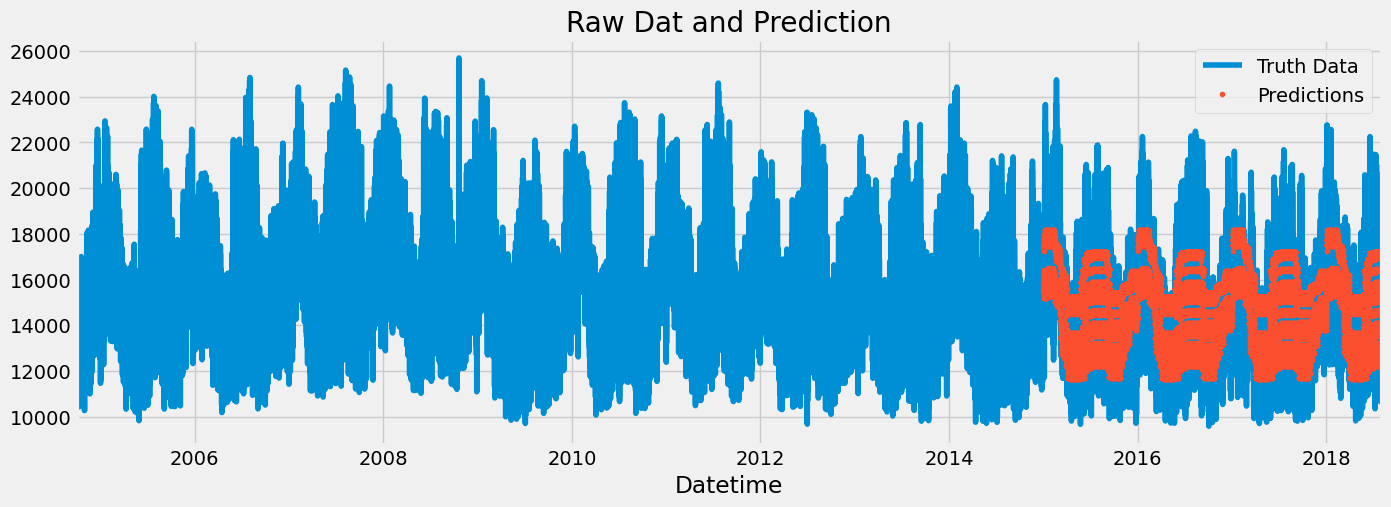

In [75]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

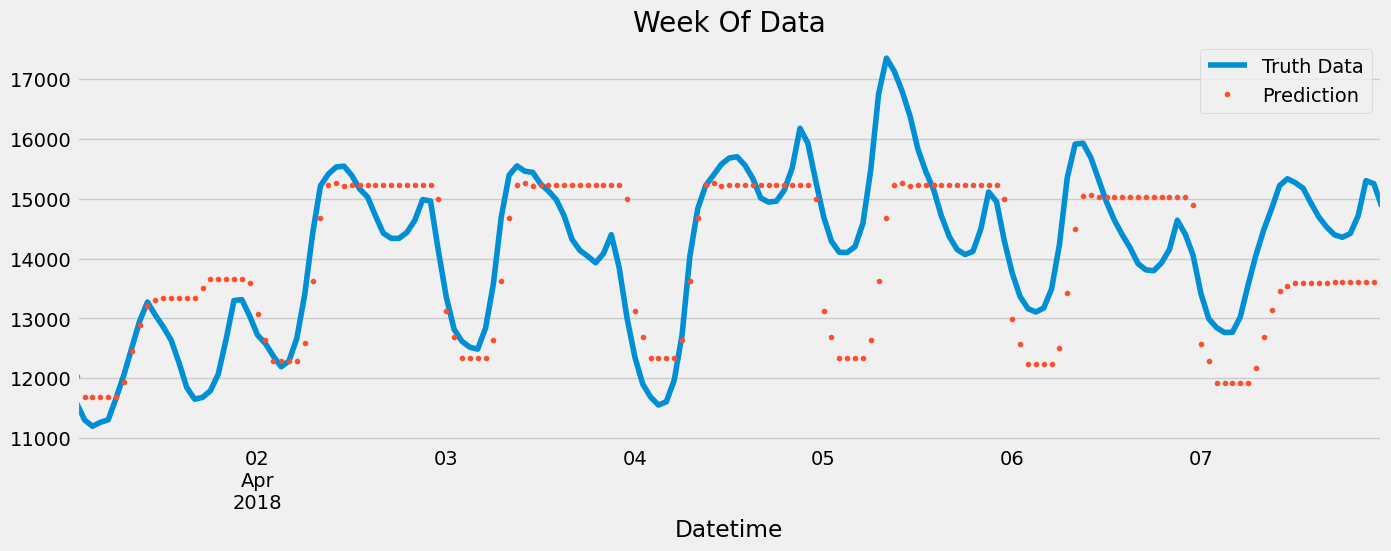

In [77]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

#### Evaluation Metrics

In [79]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1648.86


In [81]:
score = np.sqrt(mean_absolute_error(test['AEP_MW'], test['prediction']))
print(f'MAE Score on Test set: {score:0.2f}')

MAE Score on Test set: 36.37
